# <center>Project: Indoor Localization.</center>


Data : uploaded in Moodle
- train set (offline) and 
- separated (online) test set

Citation for the data: Thomas King, Stephan Kopf, Thomas Haenselmann, Christian Lubberger, Wolfgang Effelsberg, mannheim/compass, https://doi.org/10.15783/C7F30Q , Date: 20060913

## Introduction 
Recall the ML Project workflow.

Problem understanding
Data collection, Data Cleaning and Exploration
Feature Selection, Feature Engineering
Training and Model Selection
Evaluation and Deployment

## Problem Description
- Indoor localization is different than outdoor, because 
    - no line of sight, lots of distorting factors
    - needs more precision
- Examples of Applications:  
    - Logistics, Customer Support (saving time shopping), Hospitals (Patients, Device Location tracking)
- Variety of positioning technologies
    - WiFi based approaches: Received Signal Strength (RSS), angle, time of arrival, time difference of arrival
    - Bluetooth 
    - Radio Frequency
    - ...
- Challenges: 
    - poor accuracy
    - high computational complexity 
    - costs of hardware

Task: Search for a Survey paper and list some approaches present in the literature 

Task: Formulate the Problem Description, Challanges and Ml formulation

## Our project: Localization based on Received Signal Strength(RSS), using k-NN

In this project, we will work on 
  - understanding and cleaning the data,
  - organizing it in a structure suitable for analysis, and 
  - examining its statistical properties 
  - We will use a k-NN model to predict the location of new data points
  - Hyper parameter tuning, model selection

In [24]:
# Write your imports here
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import seaborn as sns 

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.filterwarnings('ignore')


### Ideas on how to structure the data. 
Task: Consider the two following obvious choices of how to store the data in a structured way and give at least a pro and a con for each:
1. transfer each row in input file to a row in data frame

**Pro:** the original data keeps intact - all AP responses stay bundled together

**Con:** the responses column has to hald a list of many signals, which makes working with it further on more complicated

2. store one signal per row. That implies that each line in the input file turns into multiple rows in the data frame.

**Pro:** tidy formal - every cell is atomic, which makes it easier to work with further on

**Con:** table gets very big - each scan line becomes N rows which might negatively influence runtime



Adopt the second approach. 

- Write a function that can process a line of the file into a matrix, and then apply it to each line.
- Create a DataFrame by concatenating the list of processed lines, stacking them. Define columns=["time", "scanMac", "posX", "posY", "posZ", "orientation", "mac", "signal", "channel", "type"]

I recommend you to get familiar with regular expressions: https://de.wikipedia.org/wiki/Regul%C3%A4rer_Ausdruck

Example: for the first line, you should have the matrix

In [2]:

# [['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:14:bf:b1:97:8a', '-38', '2437000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:0f:a3:39:e1:c0', '-54', '2462000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:14:bf:b1:97:90', '-56', '2427000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:14:bf:3b:c7:c6', '-67', '2432000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:14:bf:b1:97:81', '-66', '2422000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:14:bf:b1:97:8d', '-70', '2442000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:0f:a3:39:e0:4b', '-79', '2462000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:0f:a3:39:dd:cd', '-73', '2412000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '00:0f:a3:39:e2:10', '-83', '2437000000', '3'],
#        ['1139643118744', '00:02:2D:21:0F:33', '0.0', '0.0', '0.0', '0.0',
#         '02:00:42:55:31:00', '-85', '2457000000', '1']]

In [25]:
def read_data(path):
    # 1) Compile two regexes: one for the line header, one for each MAC=signal,channel,type
    line_re = re.compile(
        r't=(?P<time>\d+);'
        r'id=(?P<scanMac>[^;]+);'
        r'pos=(?P<posX>[^;]+);'
        r'degree=(?P<orientation>[^;]+);'
        r'(?P<responses>.+)'
    )
    resp_re = re.compile(
        r'(?P<mac>[^=;]+)='
        r'(?P<signal>-?\d+),'
        r'(?P<channel>\d+),'
        r'(?P<type>\d+)'
    )
    def process_line(line):
        """
        Parse one line of the offline trace into a list of
        [time, scanMac, posX, posY, posZ, orientation, mac, signal, channel, type].
        """
    
        m = line_re.match(line.strip())
        if not m:
            return []
    
        # extract header fields
        time        = m.group('time')
        scanMac     = m.group('scanMac')
        posX, posY, posZ = m.group('posX').split(',')
        orientation = m.group('orientation')
    
        # split off each "MAC=signal,channel,type" piece
        rows = []
        for resp in m.group('responses').split(';'):
            rm = resp_re.match(resp)
            if rm:
                rows.append([
                    time,
                    scanMac,
                    posX,
                    posY,
                    posZ,
                    orientation,
                    rm.group('mac'),
                    rm.group('signal'),
                    rm.group('channel'),
                    rm.group('type'),
                ])
        return rows
    
    # 2) Apply to every non-commented line in the file
    all_rows = []
    with open(path, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith('#'):
                continue
            all_rows.extend(process_line(line))
    
    # 3) Build the DataFrame
    columns = [
        "time", "scanMac",
        "posX", "posY", "posZ",
        "orientation",
        "mac", "signal",
        "channel", "type"
    ]
    df = pd.DataFrame(all_rows, columns=columns)
    
    # Now `df` has one signal per row, ready for cleaning, EDA, modeling…
    print(f"Parsed {len(df)} measurements.")
    return df

In [26]:
df = read_data('./data/offline.final.trace.txt')

Parsed 1181628 measurements.


## Understanding the data
Data: Thomas King, Stephan Kopf, Thomas Haenselmann, Christian Lubberger, Wolfgang Effelsberg, mannheim/compass, https://doi.org/10.15783/C7F30Q , Date: 20060913

Data Documentation, Visual inspection, Checks
Read the documentation of the data and perform a visual inspection (plain text editor). Describe the data and check that the file is as expected. Consider, for example:

- which types of lines are present and how many of them we have. Does the file fit the documentation?
- which columns we have, what they represent, which data type do they have, ...
- Note: Always keep the documentation of the data in mind, return to it if needed!

In [4]:
display(df.head())
display(df.info())

,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181628 entries, 0 to 1181627
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   time         1181628 non-null  object
 1   scanMac      1181628 non-null  object
 2   posX         1181628 non-null  object
 3   posY         1181628 non-null  object
 4   posZ         1181628 non-null  object
 5   orientation  1181628 non-null  object
 6   mac          1181628 non-null  object
 7   signal       1181628 non-null  object
 8   channel      1181628 non-null  object
 9   type         1181628 non-null  object
dtypes: object(10)
memory usage: 90.2+ MB


None

Example: 
- We see that there are comments, starting with #. Recall that we expect 146,080 lines in the file (166 locations × 8 angles × 110 recordings). Check this.
- What do you notice about the time format? 
- is id always the same?
- is degree as described in the documentation?
- Does every line have the same macs
- how are Signal Strength values?
...

> Continue by documenting what you notice about the data

In [5]:
df["scanMac"].unique()

array(['00:02:2D:21:0F:33'], dtype=object)

all measurements have been performed with the same device

In [6]:
df["time"].nunique()

146074

the amount of different timestamps mostly aligns with the expected amount (146 080) except for 6 missing values

In [7]:
df["orientation"].unique()
# TODO: transform column orientation to only contain one of the 8 documented orientations

array(['0.0', '45.2', '90.3', '135.9', '180.3', '225.6', '270.1', '315.0',
       '45.1', '90.7', '135.2', '180.1', '225.7', '269.7', '315.3', '0.3',
       '45.5', '90.5', '135.7', '180.2', '225.0', '270.9', '315.2', '0.7',
       '45.7', '89.8', '225.2', '269.9', '0.4', '90.4', '134.8', '180.4',
       '0.2', '45.6', '135.0', '179.6', '225.4', '269.5', '179.2',
       '224.5', '89.9', '134.4', '269.4', '359.9', '90.1', '135.1',
       '270.2', '314.8', '313.8', '45.8', '90.8', '134.9', '225.9',
       '270.5', '315.9', '45.4', '134.7', '180.0', '224.9', '269.8',
       '314.4', '0.1', '44.3', '225.3', '315.7', '0.5', '44.8', '89.4',
       '226.0', '315.1', '0.8', '89.2', '180.8', '224.8', '315.8', '44.4',
       '180.5', '314.9', '44.9', '179.8', '315.5', '135.6', '0.6',
       '135.4', '179.9', '225.1', '270.0', '45.3', '270.4', '45.0',
       '90.6', '46.0', '0.9', '44.6', '135.3', '90.2', '134.2', '44.5',
       '134.5', '226.1', '269.6', '270.3', '315.4', '1.5', '135.8',
       

the column orientation contains way more orientations than described in the documentations - so, the values will be transformed by assigning each value to the one (of the 8 mentioned orientations) it is closest to

In [8]:
df["mac"].value_counts()

mac
00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
02:64:fb:68:52:e6     50852
00:0f:a3:39:e0:4b     43508
02:2e:58:22:f1:ac     25112
00:0f:a3:39:e2:10     19162
02:37:fd:3b:54:b5      8732
02:b7:00:bb:a9:35      7602
02:5c:e0:50:49:de      6997
00:04:0e:5c:23:fc       418
00:30:bd:f8:7f:c5       301
00:e0:63:82:8b:a9       103
02:42:1c:4e:b5:c0         1
02:0a:3d:06:94:88         1
02:4f:99:43:30:cd         1
Name: count, dtype: int64

there are more mac addresses than access points - so, we need to identify which measurements came from the documented access points

In [9]:
df["type"].value_counts()
# TODO: delete rows with type=1

type
3    978443
1    203185
Name: count, dtype: int64

there are many rows that contain signals measured from adhoc devices (not access points) which have to be deleted

In [10]:
df_copy = df.copy()
numeric_cols = ['time', 'posX', 'posY', 'posZ', 'orientation', 'signal', 'channel', 'type']
for col in numeric_cols:
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

In [11]:
display(df_copy["signal"].describe())

count    1.181628e+06
mean    -6.385398e+01
std      1.262409e+01
min     -9.900000e+01
25%     -7.300000e+01
50%     -6.200000e+01
75%     -5.500000e+01
max     -2.500000e+01
Name: signal, dtype: float64

###   Cleaning and formatting the data:

- Convert numeric variables from string to numeric
- look at the orientation and notice that the values are not always exact multiples of 45 degrees.  Write a function that rounds the orientation to multiples of 45 degrees and add column with rounded angles. Keep the old values and check that the conversion was done properly. Note that 358 should be converted to 0. 
- Plot the ECDF of the orientation column before and after the conversion(from statsmodels.api, use distributions.ECDF)
- keep only Access Points(abrev. AP), i.e. remove ad-hoc devices and then remove the type column
- format the time column

As mentioned, keep the unchanged columns for now as well

After this steps, the first lines of your data frame should look like:

![](step1.png)


### Univariate Analysis

- Are there other columns that you can eliminate?
- Can you identify the 6 APs that are mentioned in the documentation?
- Was the same device used for taking the measurements?
- ...

For answering this questions, review unique values, counts, look at measures of central tendency and spread for the numerical variables, ...

You should be able to argue a reduction to 7 AP, deleting the channel, and scanMac

In [12]:
df_copy["mac"].value_counts()

mac
00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
02:64:fb:68:52:e6     50852
00:0f:a3:39:e0:4b     43508
02:2e:58:22:f1:ac     25112
00:0f:a3:39:e2:10     19162
02:37:fd:3b:54:b5      8732
02:b7:00:bb:a9:35      7602
02:5c:e0:50:49:de      6997
00:04:0e:5c:23:fc       418
00:30:bd:f8:7f:c5       301
00:e0:63:82:8b:a9       103
02:42:1c:4e:b5:c0         1
02:0a:3d:06:94:88         1
02:4f:99:43:30:cd         1
Name: count, dtype: int64

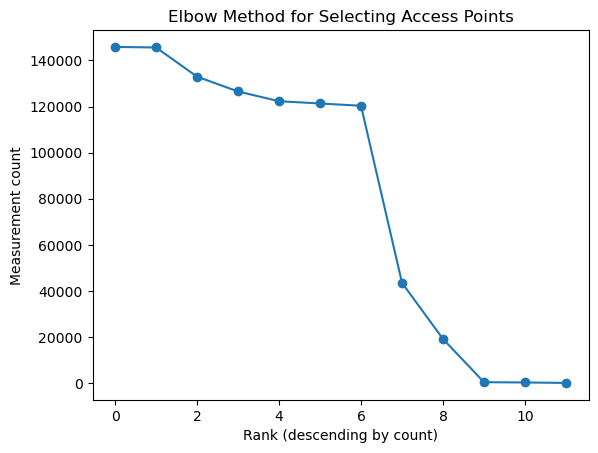

Elbow at rank 7: selecting the first 7 MAC addresses

Selected MAC addresses:
1. 00:0f:a3:39:e1:c0 (145862 measurements)
2. 00:0f:a3:39:dd:cd (145619 measurements)
3. 00:14:bf:b1:97:8a (132962 measurements)
4. 00:14:bf:3b:c7:c6 (126529 measurements)
5. 00:14:bf:b1:97:90 (122315 measurements)
6. 00:14:bf:b1:97:8d (121325 measurements)
7. 00:14:bf:b1:97:81 (120339 measurements)


In [13]:
# 1. Compute the number of measurements for each access point
ap_counts = df_copy[df_copy['type'] == 3]['mac'].value_counts()

# 2. Sort counts in descending order and reset the index for plotting
counts_sorted = ap_counts.sort_values(ascending=False).reset_index(drop=True)

# 3. Plot the sorted counts to visualize the elbow
plt.plot(counts_sorted, marker='o')
plt.xlabel('Rank (descending by count)')
plt.ylabel('Measurement count')
plt.title('Elbow Method for Selecting Access Points')
plt.show()

# 4. Identify the elbow point as the position with the largest absolute change
deltas = counts_sorted.diff().abs()
elbow_index = deltas[1:].idxmax()  # skip the first NaN
num_selected = elbow_index + 1     # convert zero-based index to count

print(f"Elbow at rank {elbow_index}: selecting the first {elbow_index} MAC addresses")

# 5. Extract the top MAC addresses based on the elbow point
selected_macs = ap_counts.nlargest(elbow_index).index.tolist()

print("\nSelected MAC addresses:")
for rank, mac in enumerate(selected_macs, start=1):
    print(f"{rank}. {mac} ({ap_counts[mac]} measurements)")


The elbow point occurs at the 7th MAC address, it indicates that the first 7 MACs contain the majority of reliable data

In [14]:
df["posZ"].value_counts()

posZ
0.0    1181628
Name: count, dtype: int64

## Organize your code


Write a function that summarizes the processing of the data. Write it in such a way that you can apply it to the online data set as well. Check that the  you obtain the same result as until now, ensuring that none of the steps were forgotten.

You can use the pickle format to save a DataFrame, which preserves the data types of the columns. What you should obtain is available in moodle, as pickle file

In [27]:
def cleaning(dataframe):
    # 1) Convert numeric variables from strings to appropriate numeric types
    numeric_cols = ['time', 'orientation', 'signal', 'channel', 'type']
    for col in numeric_cols:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')

    # 2) Remove duplicate rows
    dataframe = dataframe.drop_duplicates()
    
    # 3) Keep only infrastructure APs (type==3) and drop the `type` column
    dataframe = dataframe[dataframe['type'] == 3].drop(columns=['type'])
    
    # 4) Convert `time` from milliseconds since epoch to datetime
    DF_TIME_UNIT = 'ms'  # adjust if needed
    dataframe.rename(columns={'time': 'rawTime'}, inplace=True) # rename to match reference
    dataframe['time'] = pd.to_datetime(dataframe['rawTime'], unit=DF_TIME_UNIT)
    
    # 5) remove MACs that don't occur often
    mac_counts = dataframe["mac"].value_counts()
    reference_aps = mac_counts.sort_values(ascending=False).head(7).index.tolist()
    print(f"reference APs: {reference_aps}")
    dataframe = dataframe[dataframe["mac"].isin(reference_aps)]
    
    # 6) transform coordinates
    dataframe['posXY'] = dataframe['posX'].astype(str) + '-' + dataframe['posY'].astype(str)
    dataframe = dataframe.drop(columns=['posZ'])


    return dataframe

def round_orientation(angles):
    nearest_section = np.round(angles / 45)
    rounded = int(nearest_section* 45) % 360
    return rounded


In [28]:
df = cleaning(df)

reference APs: ['00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:81']


In [ ]:
round_orientation(22.4), round_orientation(22.5)

In [29]:
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 904985 entries, 0 to 1181626
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   rawTime      904985 non-null  int64         
 1   scanMac      904985 non-null  object        
 2   posX         904985 non-null  object        
 3   posY         904985 non-null  object        
 4   orientation  904985 non-null  float64       
 5   mac          904985 non-null  object        
 6   signal       904985 non-null  int64         
 7   channel      904985 non-null  int64         
 8   time         904985 non-null  datetime64[ns]
 9   posXY        904985 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 75.9+ MB


None

,rawTime,scanMac,posX,posY,orientation,mac,signal,channel,time,posXY
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,2006-02-11 07:31:58.358,0.0-0.0
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,2006-02-11 07:31:58.358,0.0-0.0
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,2006-02-11 07:31:58.358,0.0-0.0
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,2006-02-11 07:31:58.358,0.0-0.0
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,2006-02-11 07:31:58.358,0.0-0.0
5,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,2006-02-11 07:31:58.358,0.0-0.0
6,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,2412000000,2006-02-11 07:31:58.358,0.0-0.0
11,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,2006-02-11 07:31:58.744,0.0-0.0
12,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-54,2462000000,2006-02-11 07:31:58.744,0.0-0.0
13,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,2006-02-11 07:31:58.744,0.0-0.0


         orientation  orientation_rounded
1181622        315.7                  315
1181623        315.7                  315
1181624        315.7                  315
1181625        315.7                  315
1181626        315.7                  315


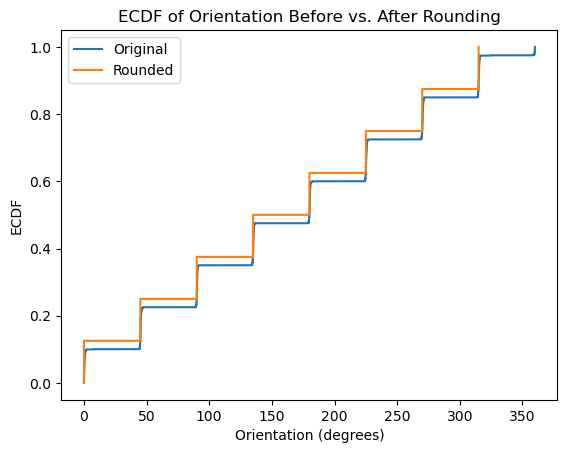

In [18]:
df['orientation_rounded'] = df['orientation'].apply(round_orientation)
# sanity check: display first few conversions
print(df[['orientation', 'orientation_rounded']].tail())
# 3) Plot ECDF before and after rounding
ecdf_before = ECDF(df['orientation'].dropna())
ecdf_after  = ECDF(df['orientation_rounded'].dropna())

plt.figure()
plt.step(ecdf_before.x, ecdf_before.y, where='post', label='Original')
plt.step(ecdf_after.x,  ecdf_after.y,  where='post', label='Rounded')
plt.xlabel('Orientation (degrees)')
plt.ylabel('ECDF')
plt.title('ECDF of Orientation Before vs. After Rounding')
plt.legend()
plt.show()

In [19]:
df["orientation_rounded"].value_counts()

orientation_rounded
0      113479
315    113369
135    113225
270    113133
90     113046
45     112978
180    112921
225    112834
Name: count, dtype: int64

# Try to get the same dataframe as uploaded in moodle

In [20]:
import sys
import numpy as np
import pickle

# Make numpy._core.numeric point to numpy.core.numeric
sys.modules['numpy._core.numeric'] = np.core.numeric

# Now load your pickle
with open('df.pkl', 'rb') as f:
    df_reference = pickle.load(f)

df_reference = pd.DataFrame(df_reference)
display(df_reference.head())
display(df_reference.info())

,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY
0,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,0,1139643118358,0.0-0.0
1,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,0,1139643118358,0.0-0.0
2,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,0,1139643118358,0.0-0.0
3,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,0,1139643118358,0.0-0.0
4,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,0,1139643118358,0.0-0.0


<class 'pandas.core.frame.DataFrame'>
Index: 903990 entries, 0 to 1181626
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         903990 non-null  datetime64[ns]
 1   posX         903990 non-null  float64       
 2   posY         903990 non-null  float64       
 3   orientation  903990 non-null  float64       
 4   mac          903990 non-null  object        
 5   signal       903990 non-null  int64         
 6   angle        903990 non-null  int64         
 7   rawTime      903990 non-null  int64         
 8   posXY        903990 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 69.0+ MB


None

In [23]:
print("Check if they are equal: " , df.equals(df_reference))
print(f"row difference: {len(df) - len(df_reference)}")

Check if they are equal:  False
row difference: 995


## EDA

We actually already did some EDA, for example, we explored 

   - the orientation, and we extracted the angle-column
   - Mac address: 
     - we managed to reduce to 7 potential AP, based on the number of measurements
     - According to the documentation, the access points consist of 5 Linksys/Cisco and one Lancom L-54g routers. We can try to look up these MAC addresses: http://coffer.com/mac_find/ vendor addresses that begin with 00:14:bf belong to Linksys devices, those beginning with 00:0f:a3 belong to Alpha Networks, and Lancom devices start with 00:a0:57. We acknowledge a discrepancy in the documentation.
  
Until now, the goal was to clean and structure the data

What will we do next: 

- Explore the data further, concentrating on investigating the properties of the response variable, signal strength.

Before designing a model, we have to know how the signals behave: 
 Does the signal strength behave similarly at all locations or does the location, orientation, access point influence the distribution? 
 We also want to characterize the relationship between the signal strength and the distance from the device to the access point. What affects this relationship?